# Install Java, Spark, and Findspark
This installs Apache Spark 3.0.0, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

In [1]:
!pip install pyspark


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz  
!tar xf spark-2.3.4-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
Set the locations where Spark and Java are installed.

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"

# Start a SparkSession
This will start a local Spark session.

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

# Use Spark!
That's all there is to it - you're ready to use Spark!

In [5]:
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])
df.show(3)

/content/spark-2.3.4-bin-hadoop2.7/python/pyspark/sql/session.py:340: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+-----+
|hello|
+-----+
|world|
|world|
|world|
+-----+
only showing top 3 rows



In [0]:
#we will close this context for now
spark.stop()

# Word count in Spark

Let's start a simple pyspark example with an histogram of words computation. Your task here is to count the number of occurences of words in a simple python string.


In [0]:
from pyspark import SparkContext
sc = SparkContext("local", "Wordcount")

In [8]:
string = ["le petit chat est mort, le petit chat est mort ce soir.\
            Il était confiné dans son panier."]

# first create the RDD from the string
words = sc.parallelize(string).flatMap(lambda line: line.split(" "))

# take care of removing the punctuation ! ',' or '.'
words2 = words.map(lambda x: x.replace(",", "").replace(".", ""))

# count the occurrence of each word
wordCounts = words2.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a +b)
print(wordCounts.collect())  

[('le', 2), ('petit', 2), ('chat', 2), ('est', 2), ('mort', 2), ('ce', 1), ('soir', 1), ('', 11), ('Il', 1), ('était', 1), ('confiné', 1), ('dans', 1), ('son', 1), ('panier', 1)]


In [0]:
# shutdown the context
sc.stop()

# PageRank with Spark

We use the [Zachary Karate Club dataset](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) for this part of the practical session. First we can inspect the nodes degrees.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

G = nx.karate_club_graph() # load Karate Club graph
pos = nx.spring_layout(G) # needed to always display the graph in the same way
print("Node Degree")
for v in G:
    print('%s %s' % (v, G.degree(v)))

Node Degree
0 16
1 9
2 10
3 6
4 3
5 4
6 4
7 4
8 5
9 2
10 3
11 1
12 2
13 5
14 2
15 2
16 2
17 2
18 2
19 3
20 2
21 2
22 2
23 5
24 3
25 3
26 2
27 4
28 3
29 4
30 4
31 6
32 12
33 17


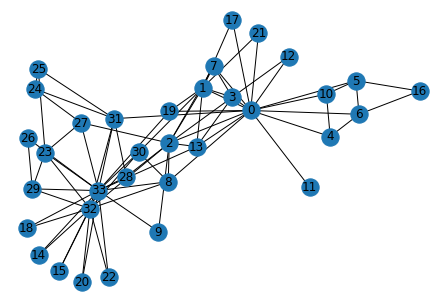

In [11]:

def draw_graph(G,pos,ranks=[],with_labels=True):
  if len(ranks) is not 0:
    nx.draw(G, pos, node_color=ranks, cmap=plt.cm.Blues, 
            with_labels=with_labels)
  else:
    nx.draw(G, pos, with_labels=with_labels)
  plt.show()

draw_graph(G,pos)

Note that you can specify a ranks table of float values, that will be used to display the rankings computed by Page Rank.

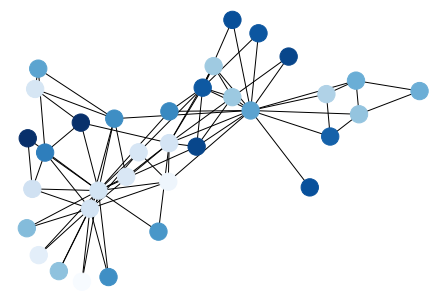

In [12]:
ranks = np.random.rand(G.number_of_nodes())
draw_graph(G,pos,ranks=ranks,with_labels=False)

In [0]:
from pyspark import SparkContext
sc = SparkContext("local", "PageRank")

In [0]:
vertices = set(G) #list vertices
verticeRDD = sc.parallelize(vertices) #TODO create RDD of vertices
neighRDD = sc.parallelize(vertices).map(lambda vertice: (vertice,pos(vertice))) #TODO create RDD of neighbors which associates one index of a node to its list of neighbors
rankRDD =  sc.parallelize(vertices).map(lambda vertice: (vertice,1)) #TODO create RDD of ranks which associates one index of a node to its rank

In [15]:
def getRanks(rankRDD):
  tab=[]
  for (link, rank) in rankRDD.collect():
    tab.append(rank)
  return tab

# a simple example to undertstand what the above functions do
test = rankRDD.collect()
print(test)
print(getRanks(rankRDD))

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1)]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Now you are ready to implement the pagerank method in pyspark !


In [0]:
#TODO add method if needed
def compute_contribs(pair):
    [url, [links,rank]] = pair
    return [[dest,rank/links.count()] for dest in links]

def pagerank(neighRDD,rankRDD,alpha=0.9,NUM_ITERATIONS = 50,display=True,verbose=True):
  for i in range(NUM_ITERATIONS): # is there a better way to test for convergence rather than doing all the iterations ?
    if verbose:
      print("Iteration {}".format(i))
      print(getRanks(rankRDD))

    # TODO
    #print(neighRDD.join(rankRDD).collect())
    contribs = neighRDD.join(rankRDD).flatMap(compute_contribs)
    rankRDD = contribs.reduceByKey(lambda x,y: x+y).mapValues(lambda x: (1-alpha) + alpha*x)

  if display:
      draw_graph(G,pos,ranks=getRanks(rankRDD),with_labels=False)
  return rankRDD

result = pagerank(neighRDD,rankRDD)

In [0]:
sc.stop()

You can compare the result you obtained with the [pagerank](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html) method from Newtorkx


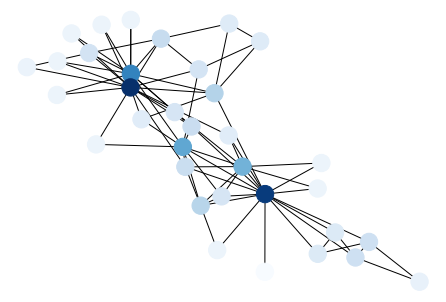

In [28]:
pr = nx.pagerank(G, alpha=0.9)
draw_graph(G,pos,ranks=list(pr.values()),with_labels=False)